# 8.1 Functional programming

*Estimated time for this notebook: 20 minutes*

We have previously seen the object-oriented style of programming, and how to organise our code according to it using objects, classes and inheritance. While widely-adopted and very useful, this is not the only way of writing code. The [*functional paradigm*](https://en.wikipedia.org/wiki/Functional_programming), as the name suggests, emphasises functions as building blocks of programs.

Understanding to think in a functional programming style is almost as
important as object orientation for building DRY, clear scientific software,
and is just as conceptually difficult.
However, being aware of different paradigms and styles gives you access to more techniques that you can use to write, structure and reason about your code.

## Functions within functions

Programs are composed of functions: they take data in (which we call
*parameters* or *arguments*) and send data out (through `return` statements).

A conceptual trick which is often used by computer scientists to teach the core
idea of functional programming is this: to write a program,
in theory, you only ever need functions with **one** argument, even when you think you need two or more. Why?

Let's define a program to add two numbers:




In [1]:
def add(a, b):
    return a + b


add(5, 6)

11



How could we do this, in a fictional version of Python which only defined functions of one argument?
In order to understand this, we'll have to understand several of the concepts
of functional programming. Let's start with a program which just adds five to
something:




In [2]:
def add_five(a):
    return a + 5


add_five(6)

11



OK, we could define lots of these, one for each number we want to add. But that
would be infinitely repetitive. So, let's try to metaprogram that: we want a
function which returns these add_N() functions.

Let's start with the easy case: a function which returns a function which adds 5 to something:




In [3]:
def generate_five_adder():
    def _five_adder(a):
        return a + 5

    return _five_adder


coolfunction = generate_five_adder()
coolfunction(7)

12



OK, so what happened there? Well, we defined a function **inside** the other function. We can always do that:




In [4]:
def thirty_function():
    def times_three(a):
        return a * 3

    def add_seven(a):
        return a + 7

    return times_three(add_seven(3))


thirty_function()

30



When we do this, the functions enclosed inside the outer function are **local** functions, and can't be seen outside:




In [5]:
add_seven

NameError: name 'add_seven' is not defined



There's not really much of a difference between functions and other variables
in python. A function is just a variable which can have () put after it to call
the code!




In [6]:
print(thirty_function)

<function thirty_function at 0x7f7190ab5280>


In [7]:
x = [thirty_function, add_five, add]

In [8]:
for fun in x:
    print(fun)

<function thirty_function at 0x7f7190ab5280>
<function add_five at 0x7f7190ab50d0>
<function add at 0x7f7190ae35e0>




And we know that one of the things we can do with a variable is `return` it. So we can return a function, and then call it outside:




In [9]:
def deferred_greeting():
    def greet():
        print("Hello")

    return greet


friendlyfunction = deferred_greeting()

In [10]:
# Do something else
print("Just passing the time...")

Just passing the time...


In [11]:
# OK, Go!
friendlyfunction()

Hello





So now, to finish this, we just need to return a function to add an arbitrary amount:




<div id="generate_adder"></div>

In [12]:
def generate_adder(increment):
    def _adder(a):
        return a + increment

    return _adder


add_3 = generate_adder(3)

In [13]:
add_3(9)

12



We can make this even prettier: let's make another variable pointing to our generate_adder() function:




In [14]:
add = generate_adder



And now we can do the real magic:




In [15]:
add(8)(5)

13

In summary, we have started with a function that takes two arguments (`add(a, b)`) and replaced it with a new function (`add(a)(b)`). This new function takes a single argument, and returns a function that itself takes the second argument.

This may seem like an overly complicated process - and, in some cases, it is! However, this pattern of functions that return functions (or even take them as arguments!) can be very useful. In fact, it is the basis of decorators, a Python feature that we will discuss more [in this chapter](./08_02_iterators_and_generators.html#Decorators) [[notebook](./08_02_iterators_and_generators.ipynb#Decorators)].

## Closures

You may have noticed something a bit weird:

In the definition of [`generate_adder`](#generate_adder), `increment` is a local variable. It should have gone out of scope and died at the end of the definition. How can the amount the returned adder function is adding still be kept?

This is called a **closure**. In Python, whenever a function definition references a variable in the surrounding scope, it is preserved within the function definition.

You can close over global module variables as well:




In [16]:
name = "Eric"


def greet():
    print("Hello, ", name)


greet()

Hello,  Eric




And note that the closure stores a reference to the variable in the surrounding scope: ("Late Binding")




In [17]:
name = "John"

greet()

Hello,  John


## Map and Reduce

We often want to apply a function to each variable in an array, to return a new array. We can do this with a list comprehension:




In [18]:
numbers = range(10)

[add_five(i) for i in numbers]

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14]



But this is sufficiently common that there's a quick built-in:




In [19]:
list(map(add_five, numbers))

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14]



This **map** operation is really important conceptually when understanding
efficient parallel programming: different computers can apply the *mapped*
function to their input at the same time. We call this Single Program, Multiple
Data (SPMD). **map** is half of the [**map-reduce**](https://en.wikipedia.org/wiki/MapReduce) functional programming
paradigm which is key to the efficient operation of much of today's "data
science" explosion. 

Let's continue our functional programming mind-stretch by looking at **reduce** operations.

We very often want to loop with some kind of accumulator (an intermediate result that we update), such as when finding a sum:




In [20]:
def summer(data):
    total = 0.0

    for x in data:
        total += x

    return total

In [21]:
summer(range(10))

45.0

 or finding a maximum:

In [22]:
import sys


def my_max(data):
    # Start with the smallest possible number
    highest = -sys.float_info.max

    for x in data:
        if x > highest:
            highest = x

    return highest

In [23]:
my_max([2, 5, 10, -11, -5])

10

In [24]:
-sys.float_info.max

-1.7976931348623157e+308

These operations, where we have some variable which is building up a result,
and the result is updated with some operation, can be gathered together as a
functional program, taking in (as an argument) the operation to be used to combine results:

In [25]:
def accumulate(operation, data, initial):
    accumulator = initial
    for x in data:
        accumulator = operation(accumulator, x)
    return accumulator


def my_sum(data):
    def _add(a, b):
        return a + b

    return accumulate(_add, data, 0)

In [26]:
my_sum(range(5))

10

In [27]:
def bigger(a, b):
    if b > a:
        return b
    return a


def my_max(data):
    return accumulate(bigger, data, -sys.float_info.max)


my_max([2, 5, 10, -11, -5])

10

Anyway, this accumulate-under-an-operation process is so fundamental to
computing that it's usually in standard libraries for languages which allow
functional programming:

In [28]:
from functools import reduce


def my_max(data):
    return reduce(bigger, data, -sys.float_info.max)


my_max([2, 5, 10, -11, -5])

10

### Efficient map-reduce

Now, because these operations, `bigger` and `_add`, are such that e.g. (a+b)+c = a+(b+c) , i.e. they are **associative**, we could apply our accumulation
to the left half and the right half of the array, each on a different computer, and then combine the two halves:

1 + 2 + 3 + 4 = (1 + 2) + (3 + 4)

Indeed, with a bigger array, we can divide-and-conquer more times:

1 + 2 + 3 + 4 + 5 + 6 + 7 + 8 = ((1 + 2) + (3 + 4)) + ((5 + 6) + (7 + 8))

So with enough parallel computers, we could do this operation on eight numbers
in three steps: first, we use four computers to do one  each of the pairwise
adds.

Then, we use two computers to add the four totals.

Then, we use one of the computers to do the final add of the two last numbers.

You might be able to do the maths to see that with an N element list, the
number of such steps is proportional to the logarithm of N.

We say that with enough computers, reduction operations are O(ln N)

This course isn't an introduction to algorithms, but we'll talk more about this
O() notation when we think about programming for performance.



## Lambda Functions



When doing functional programming, we often want to be able to define a function on the fly:




In [29]:
def most_Cs_in_any_sequence(sequences):
    def count_Cs(sequence):
        return sequence.count("C")

    counts = map(count_Cs, sequences)
    return max(counts)


def most_Gs_in_any_sequence(sequences):
    return max(map(lambda sequence: sequence.count("G"), sequences))


data = ["CGTA", "CGGGTAAACG", "GATTACA"]

most_Gs_in_any_sequence(data)

4



The syntax here means that these two definitions are identical:




In [30]:
func_name = lambda a, b, c: a + b + c


def func_name(a, b, c):
    return a + b + c




The **lambda** keyword defines an "anonymous" function.




In [31]:
def most_of_given_base_in_any_sequence(sequences, base):
    return max(map(lambda sequence: sequence.count(base), sequences))


most_of_given_base_in_any_sequence(data, "A")

3



The above fragment defined a lambda function as a **closure** over `base`. If you understood that, you've got it! 




To double all elements in an array:

In [32]:
data = range(10)
list(map(lambda x: 2 * x, data))

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

In [33]:
[2 * x for x in data]

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

Similarly, to find the maximum value in a sequence:

In [34]:
def my_max(data):
    return reduce(lambda a, b: a if a > b else b, data, -sys.float_info.max)


my_max([2, 5, 10, -11, -5])

10

## Using functional programming for numerical methods


Probably the most common use in research computing for functional programming
is the application of a numerical method to a function.

Consider this example which uses the [`newton` function from SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton.html), a root-finding function implementing the [Newton-Raphson method](http://mathworld.wolfram.com/NewtonsMethod.html). The arguments we pass to `newton` are the function whose roots we want to find, and a starting point to search from.

We will be using this to find the roots of the function $f(x) = x^2 - x$.

In [35]:
%matplotlib inline

Starting from 2, the root I found is 1.0
Starting from 0.2, the root I found is -3.441905100203782e-21


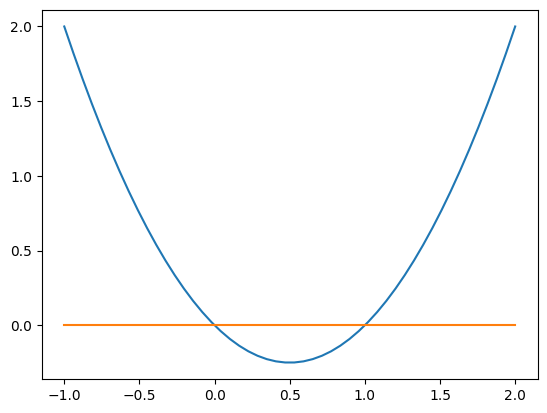

In [36]:
from matplotlib import pyplot as plt
from numpy import linspace, zeros
from scipy.optimize import newton

solve_me = lambda x: x**2 - x

for x0 in [2, 0.2]:
    answer = newton(solve_me, x0)
    print(f"Starting from {x0}, the root I found is {answer}")

xs = linspace(-1, 2, 50)
solved = [xs, list(map(solve_me, xs)), xs, zeros(len(xs))]

plt.plot(*solved)




Sometimes such tools return another function, for example the derivative of their input function. This is what a naive implementation of that could look like:




In [37]:
def derivative_simple(func, eps, at):
    return (func(at + eps) - func(at)) / eps

In [38]:
def derivative(func, eps):
    def _func_derived(x):
        return (func(x + eps) - func(x)) / eps

    return _func_derived


straight = derivative(solve_me, 0.01)

The derivative of `solve_me` is $f'(x) = 2x - 1$, which represents a straight line.
We can verify that our computations are correct, i.e. that the returned function `straight` matches $f'(x)$, by checking the value of `straight` at some $x$:

In [39]:
straight(3)

5.00999999999987

or by plotting it:

0.495000000000001


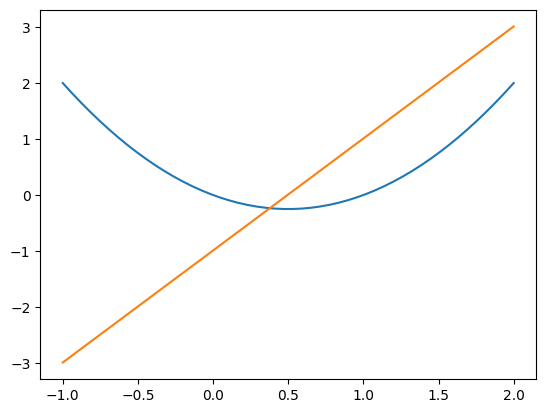

In [40]:
derived = (xs, list(map(solve_me, xs)), xs, list(map(derivative(solve_me, 0.01), xs)))
plt.plot(*derived)
print(newton(derivative(solve_me, 0.01), 0))

Of course, coding your own numerical methods is bad, because the implementations you develop are likely to be less efficient, less accurate and more error-prone than what you can find in existing established libraries.

For example, the above definition could be replaced by:

In [41]:
import scipy.misc


def derivative(func):
    def _func_derived(x):
        return scipy.misc.derivative(func, x)

    return _func_derived


newton(derivative(solve_me), 0)

0.5



If you've done a moderate amount of calculus, then you'll find similarities
between functional programming in computer science and Functionals in the
calculus of variations.

